In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# import sleap, get confidence maps on some nice data, etc...

In [5]:
import os
import io
import copy
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import sleap
import toml
import h5py
from markovids import vid

2024-06-28 15:31:02.981423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/cv2/../../lib64:
2024-06-28 15:31:02.981451: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
save_dir = "/mnt/data/jmarkow/panels/2024-06 (QD paper)"

In [7]:
fused_model = "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_fused_02/models/unet_filters_rate-1.75_training_labels-train_frames_fused_weights-(0.9, 0.1)_bpass-None.slp_repeat-0.single_instance/"

In [8]:
avi_dir = "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/keypoint_inference_export_fused_weights-(0.9, 0.1)_bpass-None"

In [9]:
avis = sorted(glob.glob(os.path.join(avi_dir, "*.avi")))

In [10]:
use_file = avis[0]
use_metadata = use_file.replace(".avi",".toml")
use_frames = range(10)
metadata = toml.load(use_metadata)

In [11]:
reflect_file = metadata["export_metadata"]["file"]
fluo_file = reflect_file.replace("-reflectance.avi","-fluorescence.avi")

In [12]:
sleap_model = sleap.load_model(fused_model)

2024-06-28 15:31:04.846098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/cv2/../../lib64:
2024-06-28 15:31:04.846124: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-28 15:31:04.846140: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-73-192): /proc/driver/nvidia/version does not exist
2024-06-28 15:31:04.895921: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flag

In [13]:
inf_model = sleap_model.inference_model

In [15]:
confmap_config = sleap_model.confmap_config

In [19]:
confmap_skeleton = confmap_config.data.labels.skeletons

In [23]:
confmap_node_names = [_.name for _ in confmap_skeleton[0].nodes]

In [32]:
use_pred_vid_obj = sleap.Video.from_filename(use_file)
use_fluo_vid_obj = sleap.Video.from_filename(fluo_file)
use_reflect_vid_obj = sleap.Video.from_filename(reflect_file)


In [33]:
dirname = os.path.dirname(fluo_file)
basename = os.path.splitext(os.path.basename(fluo_file))[0]

In [34]:
bground_name = os.path.join(dirname, "_bground", f"{basename}.hdf5")

In [35]:
with h5py.File(bground_name, "r") as f:
    bgrounds = f["bground"][()]
    bgrounds_idxs = f["frame_idxs"][()]

In [36]:
pred_frames = use_pred_vid_obj.get_frames(use_frames)
fluo_frames = use_fluo_vid_obj.get_frames(use_frames) 
reflect_frames = use_reflect_vid_obj.get_frames(use_frames)

In [37]:
single_instance_layer = inf_model.single_instance_layer
single_instance_layer.return_confmaps = True

In [38]:
results = single_instance_layer(pred_frames)
confmaps = results["confmaps"].numpy().squeeze()

2024-06-28 15:34:55.649339: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2684354560 exceeds 10% of free system memory.
2024-06-28 15:34:55.880453: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2684354560 exceeds 10% of free system memory.
2024-06-28 15:34:56.320570: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2684354560 exceeds 10% of free system memory.
2024-06-28 15:34:56.763453: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2684354560 exceeds 10% of free system memory.
2024-06-28 15:34:57.888668: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2684354560 exceeds 10% of free system memory.
2024-06-28 15:35:15.457905: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } i

In [39]:
plt_frame = 0

In [40]:
output_scale = confmaps[plt_frame].shape[0] / fluo_frames[plt_frame].shape[0]

In [41]:
segmented_map = plt.matplotlib.colors.LinearSegmentedColormap

In [42]:
rng = np.random.default_rng(seed=10)

vals = np.linspace(0,1,256)
rng.shuffle(vals)
color_list = plt.cm.colors.ListedColormap(plt.cm.turbo(vals)).colors

In [43]:
node_colors = {k: v for k, v in zip(confmap_node_names, color_list.tolist())}

In [44]:
# color_list = plt.cm.colors.ListedColormap(rng.random(size=(256,3))).colors

In [45]:
use_roi = np.array([300, 700, 500, 900])
confmap_roi = np.round(use_roi * output_scale).astype("int")

In [46]:
from qd_analysis.fig import setup_plotting_env

In [50]:
confmap_node_names

['foreleg_L',
 'foreleg_R',
 'hindleg_L',
 'hindleg_R',
 'back_top',
 'back_middle',
 'back_bottom',
 'tail_base',
 'tail_middle',
 'tail_tip']

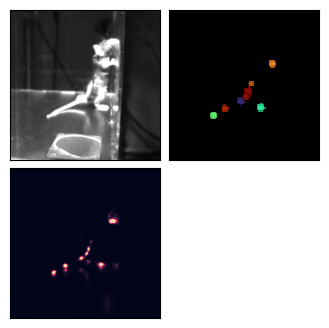

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4))

ax[0, 0].imshow(
    reflect_frames[plt_frame][
        use_roi[0] : use_roi[1], use_roi[2] : use_roi[3]
    ].squeeze(),
    cmap="gray",
    vmin=0,
    vmax=255,
)
bground_sub = np.clip(fluo_frames[plt_frame].astype("int").squeeze() - bgrounds[0], 0, np.inf)
ax[1, 0].imshow(
    bground_sub[use_roi[0] : use_roi[1], use_roi[2] : use_roi[3]].squeeze(),
    cmap="rocket",
    vmin=0,
    vmax=255,
)
for _node, _idx in zip(confmap_node_names, range(confmaps[plt_frame].shape[-1])):
    use_map = confmaps[
        plt_frame, confmap_roi[0] : confmap_roi[1], confmap_roi[2] : confmap_roi[3], _idx
    ].squeeze()

    new_cmap = plt.cm.colors.LinearSegmentedColormap.from_list(
        name=_idx, colors=[[0, 0, 0], node_colors[_node]], N=1000,
    )
    masked_data = np.ma.masked_where(use_map < 0.6, use_map)
    new_cmap.set_bad([0, 0, 0, 0])
    ax[0, 1].set_facecolor([0, 0, 0])
    ax[0, 1].imshow(
        masked_data,
        # alpha=0.25,
        origin="upper",
        vmin=0,
        vmax=1,
        extent=[
            -0.5,
            use_map.shape[1] / output_scale - 0.5,
            use_map.shape[0] / output_scale - 0.5,
            -0.5,
        ],
        cmap=new_cmap,
        interpolation="none",
    )
ax[1,1].axis("off")
for _ax in ax.ravel():
    _ax.set_xticks([])
    _ax.set_yticks([])
fig.subplots_adjust(hspace=.05, wspace=.05)
fig.savefig(os.path.join(save_dir, "beads_v2_labeling_confidence_map_output.pdf"), bbox_inches="tight", dpi=600)

In [52]:
# ALSO SHOW A LABELING EXAMPLE!

In [53]:
from segments import SegmentsClient

# You can find your api key at https://segments.ai/account
api_key = "1978af2b394403a851cb1cabaa6050da00c838f5"
client = SegmentsClient(api_key)

INFO:segments.client:Initialized successfully.


In [54]:
dataset_name = "jmarkow/basler-nir-plexiglass-arena-keypoints-fused" 
samples = client.get_samples(dataset_name, per_page=1000, label_status=["REVIEWED"])
pre_segments_labels = [(client.get_label(_sample.uuid), _sample) for _sample in samples]

In [55]:
# load the file straight from segments, map back to original data, etc...

In [77]:
dset = client.get_dataset(dataset_name)

In [83]:
cat_id_to_node_name = {_.id: _.name for _ in dset.task_attributes.categories}

In [56]:
use_label, use_sample = pre_segments_labels[150]

In [57]:
kpoints = use_label.attributes.annotations

In [58]:
frame_index = use_sample.metadata["frame_index"]
fluo_fname = use_sample.metadata["dat_path_fluo"]
reflect_fname = use_sample.metadata["dat_path_reflect"]

In [59]:
fluo_reader = vid.io.AutoReader(fluo_fname)
reflect_reader = vid.io.AutoReader(reflect_fname)

In [60]:
fluo_frame = fluo_reader.get_frames(frame_index).squeeze()
reflect_frame = reflect_reader.get_frames(frame_index).squeeze()

In [61]:
dirname = os.path.dirname(fluo_fname)
basename = os.path.splitext(os.path.basename(fluo_fname))[0]

In [62]:
bground_fname = os.path.join(dirname, "_bground", f"{basename}.hdf5")

In [63]:
with h5py.File(bground_fname, "r") as f:
    bgrounds = f["bground"][()]
    bgrounds_idxs = f["frame_idxs"][()]

In [64]:
use_bground = np.argmin(np.abs(frame_index - bgrounds_idxs))

In [65]:
fluo_reader.close()
reflect_reader.close()

In [66]:
bground_sub = np.clip(fluo_frame.astype("int") - bgrounds[use_bground],0,np.inf)

In [67]:
alpha = .7

In [68]:
new_im = alpha * bground_sub + (1 - alpha) * reflect_frame
new_im = (new_im - new_im.min()) / (new_im.max() - new_im.min())

In [69]:
use_roi = [600, 450, 500, 850]

In [70]:
# show images pre-synthesis...

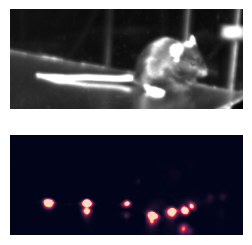

In [71]:
fig, ax = plt.subplots(2, 1, figsize=(3,3), sharex=True, sharey=True)
ax[0].imshow(reflect_frame, cmap="gray", vmin=0, vmax=255)
ax[1].imshow(bground_sub, cmap="rocket", vmin=0, vmax=255)
ax[1].set_xlim(*use_roi[2:])
ax[1].set_ylim(*use_roi[:2])
for _ax in ax:
    _ax.axis("off")
fig.savefig(os.path.join(save_dir, "beads_v2_labeling_fluorescence.pdf"), bbox_inches="tight", dpi=600)
# fig.tight_layout()

In [74]:
kpoints[0]

ImageVectorAnnotation(id=1, category_id=10, points=[[559.22, 551.24]], type='point', attributes={})

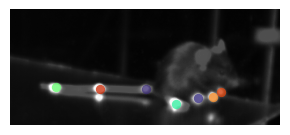

In [86]:
fig, ax = plt.subplots(1, figsize=(3, 3))
ax.imshow(new_im, cmap="gray", alpha=1.0)
for _kpoint in kpoints:
    x, y = _kpoint.points[0]
    ax.scatter(
        x,
        y,
        ec=None,
        lw=0,
        s=45,
        alpha=.75,
        fc=node_colors[cat_id_to_node_name[_kpoint.category_id]],
    )
    # ax.scatter(
    #     x,
    #     y,
    #     fc="none",
    #     s=45,
    #     alpha=1.,
    #     ec=node_colors[cat_id_to_node_name[_kpoint.category_id]],
    #     lw=.5,
    # )
ax.set_xlim(*use_roi[2:])
ax.set_ylim(*use_roi[:2])
ax.axis("off")
fig.tight_layout()
fig.savefig(os.path.join(save_dir, "beads_v2_labeling_fused_with_manual_labels.pdf"), bbox_inches="tight", dpi=600)